# 🚗 WeepingCAN Attack — Log Analysis Notebook

This notebook parses a `.jsonl` log produced by `simulation.py` and visualises the attack progression through five dedicated sections:

| § | Section | What it shows |
|---|---------|---------------|
| 1 | **Setup & Parsing** | Load the log, build structured DataFrames |
| 2 | **TEC Timeline** | Victim & attacker TEC over every cycle |
| 3 | **Phase Analysis** | Error-Active vs Error-Passive victim phase |
| 4 | **Attack Success Rate** | Effective vs wasted injection attempts |
| 5 | **Bit Injection Distribution** | Where on the frame injections land |
| 6 | **Summary Statistics** | Key numbers in a single table |

---
> **How to use**: set `LOG_PATH` in §1 to the `.jsonl` file generated by `simulation.py`, then **Run All**.

## §1 — Setup & Log Parsing

In [13]:
import json
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

warnings.filterwarnings('ignore')

# ── Matplotlib style ─────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor':  '#0d1117',
    'axes.facecolor':    '#161b22',
    'axes.edgecolor':    '#30363d',
    'axes.labelcolor':   '#c9d1d9',
    'axes.titlecolor':   '#e6edf3',
    'xtick.color':       '#8b949e',
    'ytick.color':       '#8b949e',
    'grid.color':        '#21262d',
    'grid.linewidth':    0.8,
    'text.color':        '#c9d1d9',
    'legend.facecolor':  '#161b22',
    'legend.edgecolor':  '#30363d',
    'legend.labelcolor': '#c9d1d9',
    'font.family':       'monospace',
    'font.size':         11,
    'axes.titlesize':    13,
    'axes.titleweight':  'bold',
    'axes.spines.top':   False,
    'axes.spines.right': False,
})

# ── Color palette ─────────────────────────────────────────────────────────────
C_VICTIM   = '#f78166'   # red-ish
C_ATTACKER = '#79c0ff'   # blue-ish
C_SUCCESS  = '#56d364'   # green
C_FAIL     = '#da3633'   # red
C_PHASE1   = '#1f6feb'   # blue (Error-Active)
C_PHASE2   = '#d29922'   # amber (Error-Passive)
C_BUSOFF   = '#8957e5'   # purple (Bus-Off)
C_THRESH   = '#484f58'   # grey for threshold lines

print('✔  Libraries loaded.')

✔  Libraries loaded.


In [14]:
# ╔══════════════════════════════════════════════════╗
# ║           ← CONFIGURE HERE ←                    ║
# ╚══════════════════════════════════════════════════╝

# Path to the .jsonl produced by simulation.py
# Accepts absolute paths or relative to this notebook's directory.
LOG_PATH = '../logs'   # folder → picks the most recent .jsonl automatically
                     # or set a specific file, e.g. 'logs/weepingcan_20260219_150016.jsonl'

# ── Auto-pick most recent if a folder is given ───────────────────────────────
log_path = Path(LOG_PATH)
if log_path.is_dir():
    candidates = sorted(log_path.glob('*.jsonl'))
    if not candidates:
        raise FileNotFoundError(f'No .jsonl files found in {log_path}')
    log_path = candidates[-1]

print(f'📂 Using log file: {log_path}')
print(f'   Size: {log_path.stat().st_size / 1024:.1f} KB')

📂 Using log file: ../logs/weepingcan_20260224_110747.jsonl
   Size: 287.7 KB


In [15]:
# ── Load raw records ──────────────────────────────────────────────────────────
raw: list[dict] = []
with open(log_path, encoding='utf-8') as fh:
    for line in fh:
        line = line.strip()
        if line:
            raw.append(json.loads(line))

print(f'✔  Loaded {len(raw):,} records')
print('   Level breakdown:', {k: sum(1 for r in raw if r['level']==k)
                              for k in ['INFO','BUS','ATTACK','BITS','ERRFLAG','CYCLE','STATE','SUMMARY']})

✔  Loaded 1,407 records
   Level breakdown: {'INFO': 49, 'BUS': 391, 'ATTACK': 293, 'BITS': 360, 'ERRFLAG': 239, 'CYCLE': 63, 'STATE': 2, 'SUMMARY': 10}


In [16]:
# ════════════════════════════════════════════════════════════════
#  Build DataFrames from the structured records
# ════════════════════════════════════════════════════════════════

# ── 1. Per-cycle TEC summary (from CYCLE records) ────────────────────────────
cycle_rows = [r for r in raw if r['level'] == 'CYCLE']
df_cycles = pd.DataFrame([
    {
        'cycle':          r['cycle'],
        'victim_tec':     r['victim_tec'],
        'attacker_tec':   r['attacker_tec'],
        'victim_state':   r['victim_state'],
        'attacker_state': r['attacker_state'],
    }
    for r in cycle_rows
])
print(f'✔  df_cycles: {len(df_cycles)} rows')
print(df_cycles.head(3).to_string(index=False))

# ── 2. Per-attack injection data (from ATTACK + BITS records) ────────────────
# Strategy: walk records in order, group by attack cycle.
# An attack cycle starts at level=ATTACK containing 'ATTACK CYCLE #N'.
attacks = []
current = None

for r in raw:
    msg = r['message']

    # Detect new attack cycle header
    m = re.search(r'ATTACK CYCLE #(\d+).*TEC=(\d+)', msg)
    if m:
        if current:
            attacks.append(current)
        current = {
            'attack_num':    int(m.group(1)),
            'attacker_tec_before': int(m.group(2)),
            'inject_pos':    None,
            'attacker_bit':  None,
            'victim_bit':    None,
            'bus_bit':       None,
            'bit_error':     False,
        }
        continue

    if current is None:
        continue

    # Injection position
    m = re.search(r'recessive-inject-at bit (\d+)', msg)
    if m:
        current['inject_pos'] = int(m.group(1))

    # Attacker bit sent
    m = re.search(r'Attacker bit @ pos \d+:\s+(\d)', msg)
    if m:
        current['attacker_bit'] = int(m.group(1))

    # Victim bit
    m = re.search(r'Victim\s+bit @ pos \d+:\s+(\d)', msg)
    if m:
        current['victim_bit'] = int(m.group(1))

    # Bus result
    m = re.search(r'Bus result.*:\s+(\d)', msg)
    if m:
        current['bus_bit'] = int(m.group(1))

    # Bit error flag
    if 'BIT ERROR' in msg:
        current['bit_error'] = True

if current:
    attacks.append(current)

df_attacks = pd.DataFrame(attacks)
# Merge cycle-level state info
df_attacks = df_attacks.merge(
    df_cycles[['cycle','victim_tec','victim_state']].rename(columns={'cycle':'attack_num'}),
    on='attack_num', how='left'
)
# Effective = attacker injected recessive but victim had dominant → bus reads dominant
df_attacks['effective'] = df_attacks['bit_error']

print(f'\n✔  df_attacks: {len(df_attacks)} rows')
print(df_attacks[['attack_num','inject_pos','victim_bit','bit_error','effective']].head(5).to_string(index=False))

✔  df_cycles: 63 rows
 cycle  victim_tec  attacker_tec victim_state attacker_state
     1           7             3 Error-Active   Error-Active
     2          14             6 Error-Active   Error-Active
     3          13             1 Error-Active   Error-Active

✔  df_attacks: 40 rows
 attack_num  inject_pos  victim_bit  bit_error  effective
          1          18           0       True       True
          2          13           0       True       True
          3          13           0       True       True
          4          28           0       True       True
          5          18           0       True       True


## §2 — TEC Timeline

Dual line chart showing how the **Victim TEC** climbs steadily toward Bus-Off while the **Attacker TEC** oscillates at low values thanks to the 5-valid-messages recovery mechanism.

Coloured bands mark the three CAN error state regions.

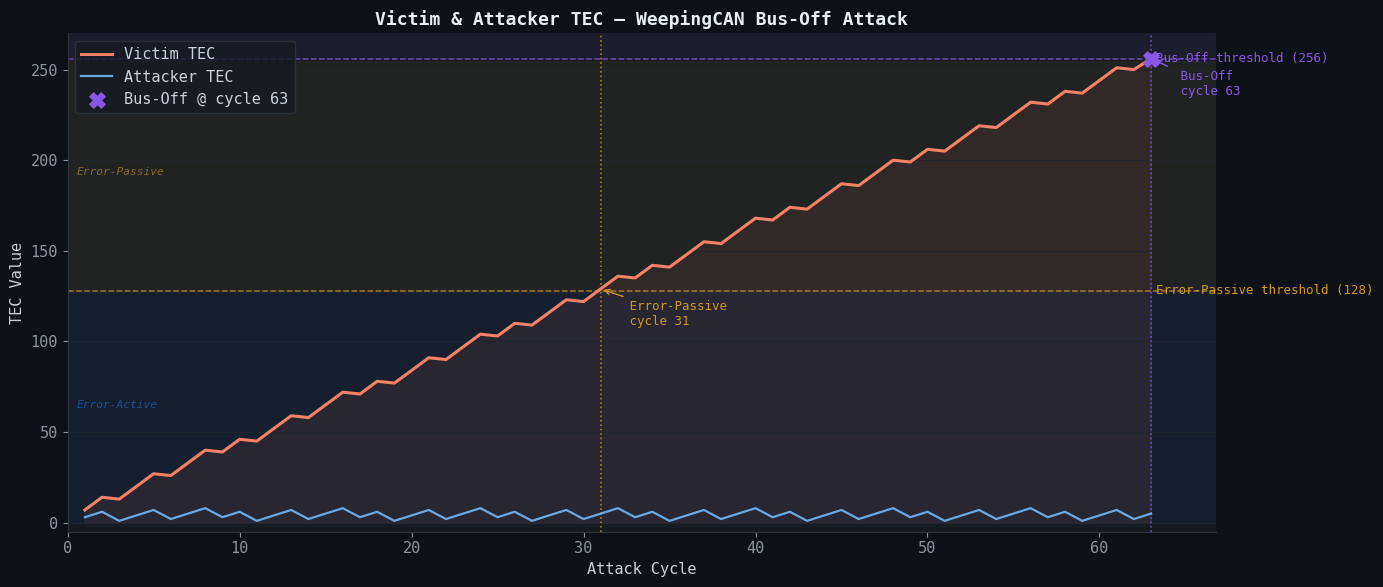

✔  Saved: plot_tec_timeline.png


In [17]:
fig, ax = plt.subplots(figsize=(14, 6))

cycles = df_cycles['cycle'].values
v_tec  = df_cycles['victim_tec'].values
a_tec  = df_cycles['attacker_tec'].values

# ── Background bands ─────────────────────────────────────────────────────────
ax.axhspan(  0, 127, alpha=0.06, color=C_PHASE1,  zorder=0, label='_nolegend_')
ax.axhspan(128, 255, alpha=0.06, color=C_PHASE2,  zorder=0, label='_nolegend_')
ax.axhspan(256, 270, alpha=0.06, color=C_BUSOFF,  zorder=0, label='_nolegend_')

# ── Threshold lines ───────────────────────────────────────────────────────────
for y, label, color in [(128, 'Error-Passive threshold (128)', C_PHASE2),
                         (256, 'Bus-Off threshold (256)',       C_BUSOFF)]:
    ax.axhline(y, color=color, linewidth=1.1, linestyle='--', alpha=0.7, zorder=1)
    ax.text(cycles[-1] + 0.3, y, label, color=color, va='center', fontsize=9)

# ── TEC lines ────────────────────────────────────────────────────────────────
ax.plot(cycles, v_tec, color=C_VICTIM,   linewidth=2.2, label='Victim TEC',   zorder=3)
ax.plot(cycles, a_tec, color=C_ATTACKER, linewidth=1.6, label='Attacker TEC', zorder=3, alpha=0.85)

# Fill under victim curve
ax.fill_between(cycles, v_tec, alpha=0.08, color=C_VICTIM)

# ── Annotate state transitions ────────────────────────────────────────────────
state_changes = df_cycles[df_cycles['victim_state'] != df_cycles['victim_state'].shift(1)]
for _, row in state_changes.iterrows():
    if row['victim_state'] != 'Error-Active':
        color = C_PHASE2 if row['victim_state'] == 'Error-Passive' else C_BUSOFF
        ax.axvline(row['cycle'], color=color, linewidth=1.2, linestyle=':', alpha=0.8)
        ax.annotate(
            f" {row['victim_state']}\n cycle {int(row['cycle'])}",
            xy=(row['cycle'], row['victim_tec']),
            xytext=(row['cycle'] + len(cycles)*0.02, row['victim_tec'] - 20),
            color=color, fontsize=9,
            arrowprops=dict(arrowstyle='->', color=color, lw=1)
        )

# ── Bus-Off marker ────────────────────────────────────────────────────────────
busoff_cycle = df_cycles[df_cycles['victim_state'] == 'Bus-Off']['cycle'].min()
if not np.isnan(busoff_cycle):
    ax.scatter([busoff_cycle], [256], color=C_BUSOFF, s=120, zorder=5,
               marker='X', label=f'Bus-Off @ cycle {int(busoff_cycle)}')

# ── Formatting ────────────────────────────────────────────────────────────────
ax.set_title('Victim & Attacker TEC — WeepingCAN Bus-Off Attack')
ax.set_xlabel('Attack Cycle')
ax.set_ylabel('TEC Value')
ax.set_ylim(-5, 270)
ax.set_xlim(0, cycles[-1] + len(cycles) * 0.06)
ax.grid(True, axis='y')
ax.legend(loc='upper left')

# Band labels on left
for y_mid, label, color in [(63,  'Error-Active',  C_PHASE1),
                              (192, 'Error-Passive', C_PHASE2)]:
    ax.text(0.5, y_mid, label, color=color, fontsize=8, alpha=0.6, style='italic')

plt.tight_layout()
plt.savefig('plot_tec_timeline.png', dpi=150, bbox_inches='tight')
plt.show()
print('✔  Saved: plot_tec_timeline.png')

## §3 — Phase Analysis: Error-Active vs Error-Passive

The attack has two distinct phases from the victim's perspective:

- **Phase 1 — Error-Active** (TEC 0–127): victim responds to errors normally, retransmits, TEC climbs +7/cycle
- **Phase 2 — Error-Passive** (TEC 128–255): victim can no longer emit Active Error Flags. The attacker's Active Flag still corrupts victim frames, but the victim cannot retaliate. TEC keeps climbing toward Bus-Off.

The bottom sub-plot shows the **per-cycle TEC increment** to highlight how consistently +7 is maintained.

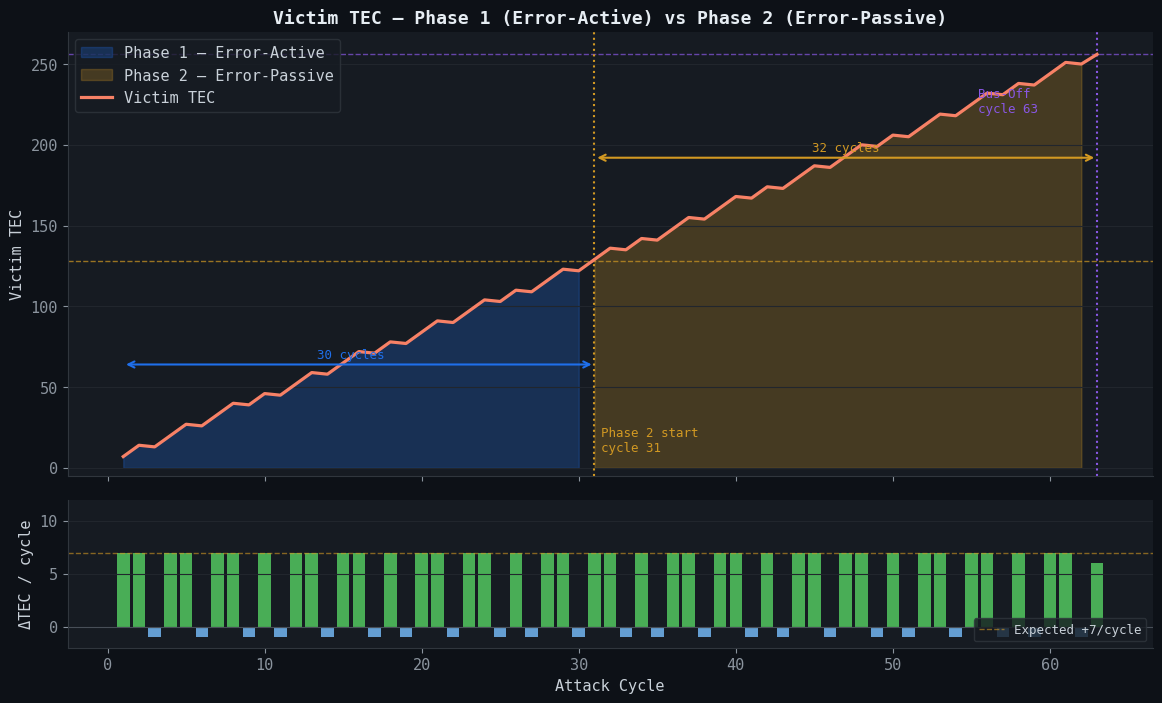

✔  Saved: plot_phase_analysis.png


In [18]:
fig, (ax_main, ax_delta) = plt.subplots(
    2, 1, figsize=(14, 8),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08},
    sharex=True
)

cycles = df_cycles['cycle'].values
v_tec  = df_cycles['victim_tec'].values

# ── Identify phase boundaries ─────────────────────────────────────────────────
phase1_mask = df_cycles['victim_state'] == 'Error-Active'
phase2_mask = df_cycles['victim_state'] == 'Error-Passive'
busoff_mask = df_cycles['victim_state'] == 'Bus-Off'

phase1_end = df_cycles[phase2_mask]['cycle'].min() if phase2_mask.any() else cycles[-1]
phase2_end = df_cycles[busoff_mask]['cycle'].min() if busoff_mask.any() else cycles[-1]

# ── Main: shaded phase areas + TEC line ──────────────────────────────────────
ax_main.fill_between(cycles, v_tec,
                     where=phase1_mask.values, alpha=0.25,
                     color=C_PHASE1, label='Phase 1 — Error-Active')
ax_main.fill_between(cycles, v_tec,
                     where=phase2_mask.values, alpha=0.25,
                     color=C_PHASE2, label='Phase 2 — Error-Passive')

ax_main.plot(cycles, v_tec, color=C_VICTIM, linewidth=2.3, zorder=3, label='Victim TEC')

# Threshold
ax_main.axhline(128, color=C_PHASE2, linewidth=1, linestyle='--', alpha=0.7)
ax_main.axhline(256, color=C_BUSOFF,  linewidth=1, linestyle='--', alpha=0.7)

# Phase boundary vertical lines
if not np.isnan(phase1_end):
    ax_main.axvline(phase1_end, color=C_PHASE2, linewidth=1.5, linestyle=':')
    ax_main.text(phase1_end + 0.4, 10, f'Phase 2 start\ncycle {int(phase1_end)}',
                 color=C_PHASE2, fontsize=9)
if not np.isnan(phase2_end):
    ax_main.axvline(phase2_end, color=C_BUSOFF, linewidth=1.5, linestyle=':')
    ax_main.text(phase2_end - len(cycles)*0.12, 220, f'Bus-Off\ncycle {int(phase2_end)}',
                 color=C_BUSOFF, fontsize=9)

# Phase duration annotations
if not np.isnan(phase1_end):
    mid1 = phase1_end / 2
    ax_main.annotate('', xy=(phase1_end, 64), xytext=(1, 64),
                     arrowprops=dict(arrowstyle='<->', color=C_PHASE1, lw=1.5))
    ax_main.text(mid1, 68, f'{int(phase1_end-1)} cycles', color=C_PHASE1,
                 ha='center', fontsize=9)
if not np.isnan(phase1_end) and not np.isnan(phase2_end):
    mid2 = (phase1_end + phase2_end) / 2
    ax_main.annotate('', xy=(phase2_end, 192), xytext=(phase1_end, 192),
                     arrowprops=dict(arrowstyle='<->', color=C_PHASE2, lw=1.5))
    ax_main.text(mid2, 196, f'{int(phase2_end - phase1_end)} cycles',
                 color=C_PHASE2, ha='center', fontsize=9)

ax_main.set_ylabel('Victim TEC')
ax_main.set_ylim(-5, 270)
ax_main.grid(True, axis='y')
ax_main.legend(loc='upper left')
ax_main.set_title('Victim TEC — Phase 1 (Error-Active) vs Phase 2 (Error-Passive)')

# ── Bottom: per-cycle TEC delta ───────────────────────────────────────────────
deltas = np.diff(v_tec, prepend=0)
colors_delta = [C_SUCCESS if d > 0 else C_ATTACKER for d in deltas]
ax_delta.bar(cycles, deltas, color=colors_delta, alpha=0.8, width=0.8)
ax_delta.axhline(7,  color=C_PHASE2, linewidth=1, linestyle='--', alpha=0.6,
                  label='Expected +7/cycle')
ax_delta.axhline(0,  color=C_THRESH, linewidth=0.8)
ax_delta.set_ylabel('ΔTEC / cycle')
ax_delta.set_xlabel('Attack Cycle')
ax_delta.legend(fontsize=9, loc='lower right')
ax_delta.set_ylim(-2, 12)
ax_delta.grid(True, axis='y')

plt.savefig('plot_phase_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('✔  Saved: plot_phase_analysis.png')

## §4 — Attack Success Rate

Not every injection attempt generates a Bit Error. If the attacker randomly picks a bit position where the victim is *already* transmitting a recessive (1), the wire-AND result is 1 — no error, no TEC update, cycle wasted.

The charts below show:
- **Top**: stacked bar — effective (Bit Error triggered) vs wasted injections per cycle window
- **Bottom**: cumulative success rate %

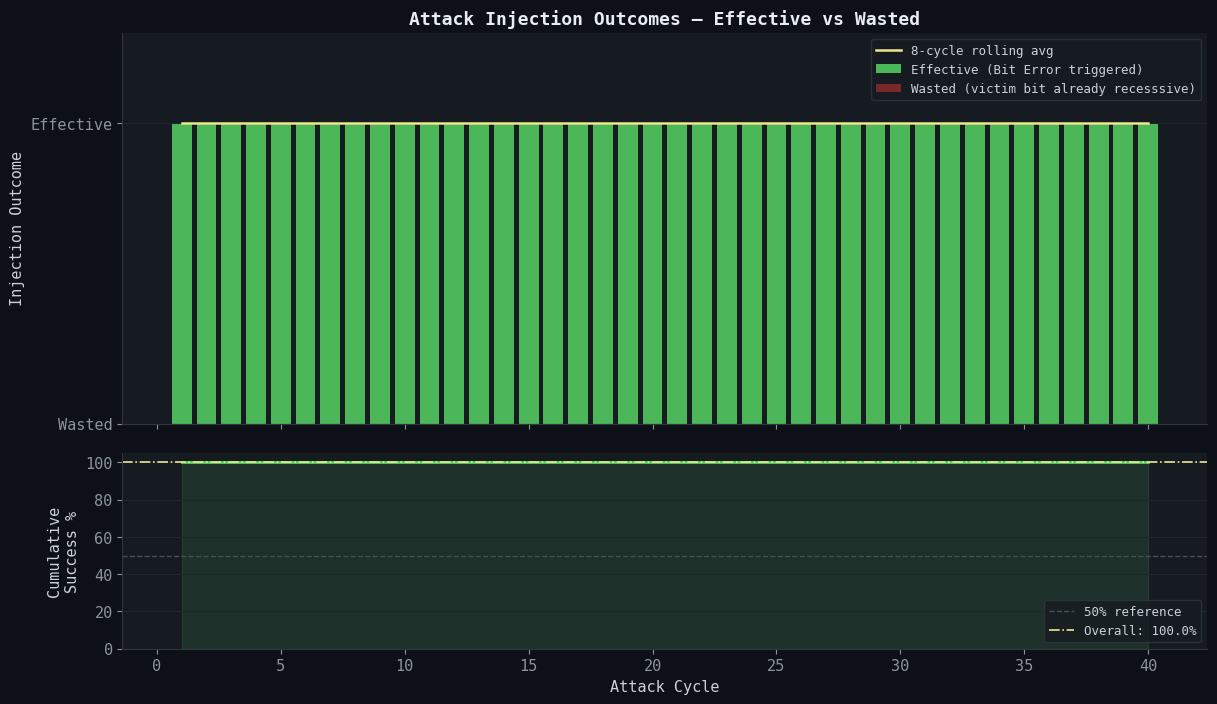

✔  Saved: plot_success_rate.png
   Overall injection success rate: 100.0%
   Effective attacks: 40 / 40


In [19]:
fig, (ax_bar, ax_cum) = plt.subplots(
    2, 1, figsize=(14, 8),
    gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.1},
    sharex=True
)

n_cycles = len(df_attacks)

# ── Per-cycle success/fail (each cycle = one injection attempt) ───────────────
success = df_attacks['effective'].astype(int).values
fail    = 1 - success
atk_cycles = df_attacks['attack_num'].values

ax_bar.bar(atk_cycles, success, color=C_SUCCESS, alpha=0.85,
           label='Effective (Bit Error triggered)', width=0.8)
ax_bar.bar(atk_cycles, fail, bottom=success, color=C_FAIL, alpha=0.5,
           label='Wasted (victim bit already recesssive)', width=0.8)

# Running window average (window=10)
window = min(10, n_cycles // 5)
rolling_success = pd.Series(success).rolling(window, min_periods=1).mean().values
ax_bar.plot(atk_cycles, rolling_success, color='#f0e68c', linewidth=1.8,
            label=f'{window}-cycle rolling avg', zorder=4)

ax_bar.set_ylabel('Injection Outcome')
ax_bar.set_ylim(0, 1.3)
ax_bar.set_yticks([0, 1])
ax_bar.set_yticklabels(['Wasted', 'Effective'])
ax_bar.legend(loc='upper right', fontsize=9)
ax_bar.set_title('Attack Injection Outcomes — Effective vs Wasted')
ax_bar.grid(True, axis='y')

# ── Cumulative success rate ───────────────────────────────────────────────────
cum_rate = np.cumsum(success) / (np.arange(n_cycles) + 1) * 100
ax_cum.plot(atk_cycles, cum_rate, color=C_SUCCESS, linewidth=2)
ax_cum.fill_between(atk_cycles, cum_rate, alpha=0.12, color=C_SUCCESS)
ax_cum.axhline(50, color=C_THRESH, linewidth=1, linestyle='--',
                label='50% reference')
overall_rate = success.mean() * 100
ax_cum.axhline(overall_rate, color='#f0e68c', linewidth=1.2, linestyle='-.',
                label=f'Overall: {overall_rate:.1f}%')
ax_cum.set_ylabel('Cumulative\nSuccess %')
ax_cum.set_xlabel('Attack Cycle')
ax_cum.set_ylim(0, 105)
ax_cum.legend(fontsize=9, loc='lower right')
ax_cum.grid(True, axis='y')

plt.savefig('plot_success_rate.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✔  Saved: plot_success_rate.png')
print(f'   Overall injection success rate: {overall_rate:.1f}%')
print(f'   Effective attacks: {success.sum()} / {n_cycles}')

## §5 — Bit Injection Distribution

The attacker chooses a **random bit position** in the DATA field (bits 11–42 for a 4-byte payload) to maintain stealth. Here we visualise:

- **Left**: histogram of all attempted injection positions
- **Right**: heatmap separating *effective* from *wasted* injections, overlaid with the victim's bit pattern

A position that maps to a victim's **dominant (0)** bit will always produce a Bit Error; a **recessive (1)** position is always wasted.

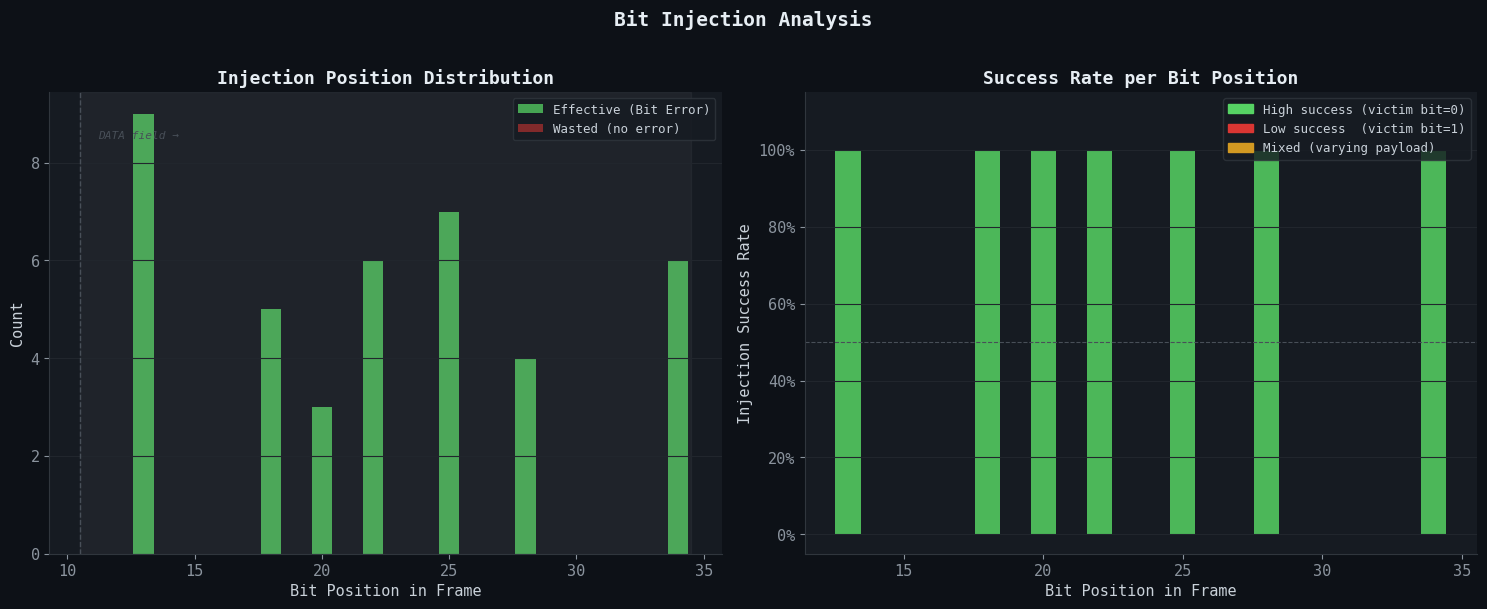

✔  Saved: plot_injection_dist.png


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

df_inj = df_attacks.dropna(subset=['inject_pos', 'victim_bit'])
all_pos      = df_inj['inject_pos'].astype(int).values
victim_bits  = df_inj['victim_bit'].astype(int).values
effective_mask = df_inj['effective'].values

pos_range = (int(all_pos.min()), int(all_pos.max()))
bins = np.arange(pos_range[0], pos_range[1] + 2) - 0.5

# ── Left: overall histogram ───────────────────────────────────────────────────
ax = axes[0]
ax.hist(all_pos[effective_mask],  bins=bins, color=C_SUCCESS, alpha=0.75,
         label='Effective (Bit Error)',  rwidth=0.8)
ax.hist(all_pos[~effective_mask], bins=bins, color=C_FAIL,    alpha=0.55,
         label='Wasted (no error)',      rwidth=0.8)

# Shade ID field area (bits 0-10)
ax.axvspan(10.5, pos_range[1] + 0.5, alpha=0.04, color='white', label='_nolegend_')
ax.axvline(10.5, color=C_THRESH, linewidth=1, linestyle='--')
ax.text(11.2, ax.get_ylim()[1] * 0.9, 'DATA field →', color=C_THRESH,
         fontsize=8, style='italic')

ax.set_title('Injection Position Distribution')
ax.set_xlabel('Bit Position in Frame')
ax.set_ylabel('Count')
ax.legend(fontsize=9)
ax.grid(True, axis='y')

# ── Right: per-position success rate heatmap bar ─────────────────────────────
ax2 = axes[1]

unique_positions = np.arange(pos_range[0], pos_range[1] + 1)
pos_counts    = np.bincount(all_pos - pos_range[0], minlength=len(unique_positions))
eff_counts    = np.bincount(all_pos[effective_mask] - pos_range[0],
                             minlength=len(unique_positions))

with np.errstate(divide='ignore', invalid='ignore'):
    success_rate = np.where(pos_counts > 0, eff_counts / pos_counts, np.nan)

# Determine dominant/recessive nature of each bit position from the data
# A position with success_rate ≈ 1.0 was always victim-dominant (0)
# A position with success_rate ≈ 0.0 was always victim-recessive (1)
colors_bar = []
for sr in success_rate:
    if np.isnan(sr):
        colors_bar.append('#30363d')
    elif sr > 0.7:
        colors_bar.append(C_SUCCESS)
    elif sr < 0.3:
        colors_bar.append(C_FAIL)
    else:
        colors_bar.append(C_PHASE2)

ax2.bar(unique_positions, np.where(np.isnan(success_rate), 0, success_rate),
        color=colors_bar, alpha=0.85, width=0.9)
ax2.axhline(0.5, color=C_THRESH, linewidth=0.8, linestyle='--')

ax2.set_title('Success Rate per Bit Position')
ax2.set_xlabel('Bit Position in Frame')
ax2.set_ylabel('Injection Success Rate')
ax2.set_ylim(-0.05, 1.15)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax2.grid(True, axis='y')

legend_els = [
    mpatches.Patch(color=C_SUCCESS, label='High success (victim bit=0)'),
    mpatches.Patch(color=C_FAIL,    label='Low success  (victim bit=1)'),
    mpatches.Patch(color=C_PHASE2,  label='Mixed (varying payload)'),
]
ax2.legend(handles=legend_els, fontsize=9)

plt.suptitle('Bit Injection Analysis', fontsize=14, fontweight='bold',
             color='#e6edf3', y=1.01)
plt.tight_layout()
plt.savefig('plot_injection_dist.png', dpi=150, bbox_inches='tight')
plt.show()
print('✔  Saved: plot_injection_dist.png')

## §6 — Summary Statistics

A concise single-table view of the key metrics extracted from this simulation run.

In [21]:
total_cycles    = len(df_cycles)
total_attacks   = len(df_attacks)
effective_att   = int(df_attacks['effective'].sum())
wasted_att      = total_attacks - effective_att
success_pct     = effective_att / total_attacks * 100 if total_attacks else 0

busoff_cycle    = df_cycles[df_cycles['victim_state'] == 'Bus-Off']['cycle'].min()
phase2_cycle    = df_cycles[df_cycles['victim_state'] == 'Error-Passive']['cycle'].min()

phase1_len = int(phase2_cycle - 1)  if not np.isnan(phase2_cycle) else total_cycles
phase2_len = int(busoff_cycle - phase2_cycle) if not np.isnan(busoff_cycle) and not np.isnan(phase2_cycle) else 'N/A'

# TEC net gain per effective cycle
victim_tec_arr = df_cycles['victim_tec'].values
deltas_eff     = np.diff(victim_tec_arr)
avg_tec_gain   = deltas_eff[deltas_eff > 0].mean() if len(deltas_eff[deltas_eff > 0]) else 0

max_attacker_tec = df_cycles['attacker_tec'].max()

rows = [
    ('Total simulation cycles',       total_cycles),
    ('Total injection attempts',       total_attacks),
    ('Effective injections (Bit Error)',f'{effective_att}  ({success_pct:.1f}%)'),
    ('Wasted injections',              f'{wasted_att}  ({100-success_pct:.1f}%)'),
    ('─────────────────────────', '────────────────────'),
    ('Phase 1 duration (Error-Active)', f'{phase1_len} cycles'),
    ('Phase 2 duration (Error-Passive)',f'{phase2_len} cycles'),
    ('Victim Bus-Off at cycle',         int(busoff_cycle) if not np.isnan(busoff_cycle) else 'Not reached'),
    ('─────────────────────────', '────────────────────'),
    ('Avg victim TEC gain / effective cycle', f'+{avg_tec_gain:.2f}'),
    ('Attacker TEC peak',               max_attacker_tec),
    ('Attacker final state',            df_cycles.iloc[-1]['attacker_state']),
    ('Attacker ever left Error-Active?',
     '✅ No' if (df_cycles['attacker_state'] == 'Error-Active').all() else '❌ YES'),
]

df_summary = pd.DataFrame(rows, columns=['Metric', 'Value'])
df_summary = df_summary.set_index('Metric')

# Style
styled = df_summary.style.set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#161b22'), ('color', '#79c0ff'),
        ('font-family', 'monospace'), ('border', '1px solid #30363d')]},
    {'selector': 'td', 'props': [
        ('background-color', '#0d1117'), ('color', '#c9d1d9'),
        ('font-family', 'monospace'), ('border', '1px solid #21262d'),
        ('padding', '6px 12px')]},
]).set_caption('WeepingCAN Simulation — Summary Statistics')

display(styled)

,Value
Metric,
Total simulation cycles,63
Total injection attempts,40
Effective injections (Bit Error),40 (100.0%)
Wasted injections,0 (0.0%)
─────────────────────────,────────────────────
Phase 1 duration (Error-Active),30 cycles
Phase 2 duration (Error-Passive),32 cycles
Victim Bus-Off at cycle,63
─────────────────────────,────────────────────


In [22]:
print('📊 All plots saved in current directory:')
for f in ['plot_tec_timeline.png', 'plot_phase_analysis.png',
          'plot_success_rate.png', 'plot_injection_dist.png']:
    p = Path(f)
    if p.exists():
        print(f'   ✔  {f}  ({p.stat().st_size//1024} KB)')
    else:
        print(f'   ✗  {f}  (not found — run the cell above)')

📊 All plots saved in current directory:
   ✔  plot_tec_timeline.png  (127 KB)
   ✔  plot_phase_analysis.png  (109 KB)
   ✔  plot_success_rate.png  (77 KB)
   ✔  plot_injection_dist.png  (86 KB)
